In [1]:
import pyMMF
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.linalg import expm
from colorsys import hls_to_rgb
import pickle, os, sys, glob
sys.path.append("../common")
from functions import (
    stack_correlation, 
    fidelity, 
    get_disk_mask,
    load_complex32,
    get_color_map
)
from functions import colorize, logplotTM, get_color_map

%matplotlib inline

Set `FIBER` to:
- `Draka_GRIN` for the [Prysmina BendBright™ OM4 fiber](https://www.prysmiangroup.com/en/bendbright-tm-om4),
- `TL_GRIN`, for a segment of the [Tholabs OM2 GIF50C fiber](https://www.thorlabs.de/thorProduct.cfm?partNumber=GIF50C)
- `TL_GRIN_2` or `TL_GRIN_3` for two segment of the same [Tholabs OM2 GIF50C fiber](https://www.thorlabs.de/thorProduct.cfm?partNumber=GIF50C) from a different spool

In [2]:
FIBER = "Draka_GRIN"
# FIBER = 'TL_GRIN3'

DATA_PATH = Path("../Data/") / FIBER
# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name, full_name=False):
    full_file_name = FIBER + "_" + file_name if full_name else file_name
    path = DATA_PATH / full_file_name
    print("==> File path:", str(path.absolute().resolve(strict=False)))
    return str(path)


def image_path(file_name, full_name=False):
    full_file_name = FIBER + "_" + file_name if full_name else file_name
    path = IMAGE_FOLDER / full_file_name
    print("==> Image path:", str(path.absolute().resolve(strict=False)))
    return str(path)

In [3]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
SHOW_GRID = False
FIGSIZE = (8, 5)
SAVE_FIG = False

DEFORMATION_TO_SHOW = [0, 1, 2, 3, 4]

## I. Load data

### A. Load parameters of the fiber and the experiment

In [4]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")


# number of pixels in each axis in the input plane (DMD)
N_in = param["fiber"]["inpoints"]
# number of pixels in each axis in the output plane (camera)
N_out = param["fiber"]["onpoints"]

# angles of rotation of the input wavefronts
angles = param["RME"]["angles"]
n_a = param["RME"]["n_angles"]
# number of random input wavefronts
n_rnd = param["RME"]["n_rnd"]
nv_max = param["RME"]["nv_max"]

# number of operatoirs
n_op = param["RME"]["n_op"]
# number of the first modes of each operator sent to the DMD
n_rm = param["RME"]["n_rm"]
n_angles_for_corr = param["RME"]["n_ang_corr"]


# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param_small = pickle.load(file, encoding="latin1")

# number of deformation values stored in the demo
# (the actual full dataset has 30 deformation values)
n_deform = param_small["n_deform"]

# deformation indices used in the demo
deformation_indices = param_small["deformation_indices"]

# deformation values
Delta_x = param_small["Delta_x"]

==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/param.pkl
==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/param_small.pkl


### B. Load the measured output fields corresponding to rotated inputs for different deformations 

**load and concatenate the measurements for random input at different levels of deformation**

In [5]:
filepaths = sorted(
    glob.glob(file_path("Ys_rnd_small_*.npz")),
    key=lambda x: int(x.split("_")[-1].split(".")[0]),
)
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd = np.stack(arrays, axis=0)

==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/Ys_rnd_small_*.npz


In [6]:
filepaths = glob.glob(file_path("Ys_rnd_small_p1_*.npz"))

==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/Ys_rnd_small_p1_*.npz


In [7]:
filepaths = glob.glob(file_path("Ys_rnd_small_p1_*.npz"))

# Sort the filenames based on the numerical value of <xx>
filepaths = sorted(filepaths, key=lambda x: int(re.search(r'Ys_rnd_small_p1_(\d+).npz', x).group(1)))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd = np.stack(arrays, axis=0)

==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/Ys_rnd_small_p1_*.npz


**load results of rotated focusing using the RME**

In [8]:
Ys_focus = np.load(file_path("Ys_focus_small.npy"))  # amplitude only

==> File path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/Data/TL_GRIN3/Ys_focus_small.npy


### C. Load the modes

In [9]:
modes = np.load(os.path.join(DATA_PATH, "modes.npz"))
Mout = modes["modes_out"].astype(np.complex64)
m = modes["m"]
l = modes["l"]

### D. Load the TMs in the mode basis

In [19]:
TMs_mode = np.load(DATA_PATH / "TMs_mode.npy")
DEFORMATION_TO_SHOW = DEFORMATION_TO_SHOW[:len(TMs_mode.shape)]
n_modes = TMs_mode.shape[-1]
# select one polarization, and take only the deformation values used in the demo
TMs = TMs_mode[DEFORMATION_TO_SHOW, :n_modes, :]

### E. Prepare the data
* Clip with a disk mask
* Remove mean field value (for correlation calculation)
* Change axis order

In [20]:
# create mask to focus on the central part of the output plane
mask_output = (
    get_disk_mask([N_out, N_out], 0.74 * N_out / 2).flatten().astype(np.complex64)
)

# move the axis so that the penultimate one corresponds to angles
Ys_rnd = np.moveaxis(Ys_rnd, -3, -2)

I_rnd = np.abs(Ys_rnd) ** 2

DEFORMATION_TO_SHOW = [d for d in DEFORMATION_TO_SHOW if d < Ys_rnd.shape[0]]

### F. Show the TMs in the mode basis

Text(0.5, 1.0, '$\\Delta x = 60 \\mu m$')

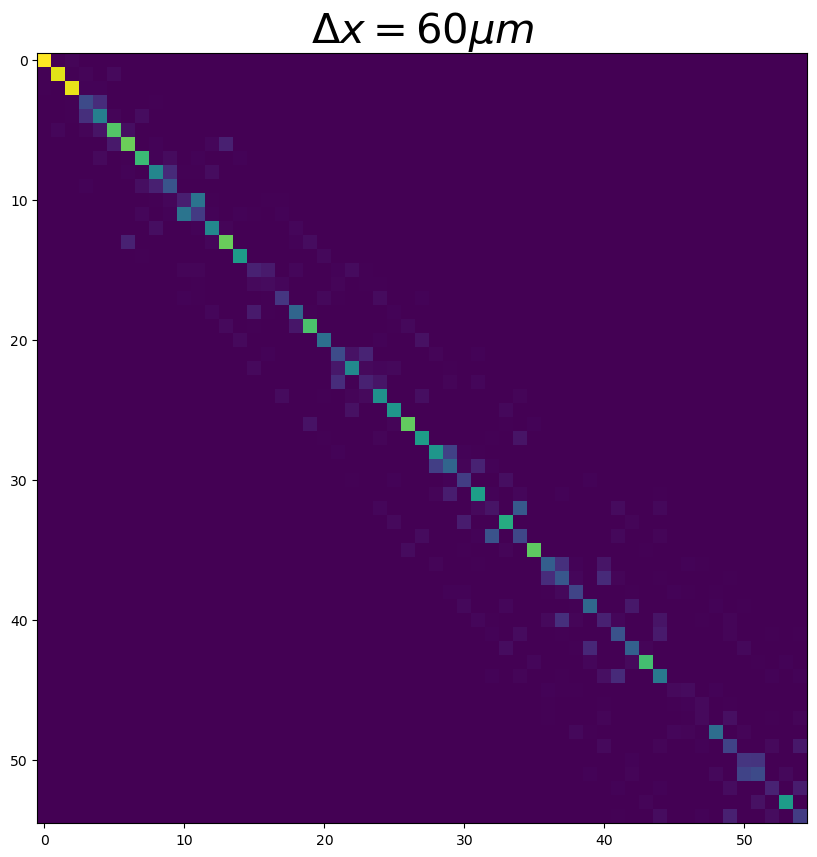

In [21]:
modes

ind_deformation = -1
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(TMs[ind_deformation]) ** 2)
plt.title(
    rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$", fontsize=SUP_TITLE_SIZE
)

## II Observation of the RME

### A. Rotation of output focusing using the RME
We show **amplitude** for the sake of clarity

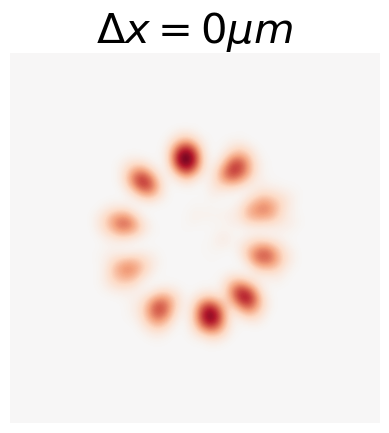

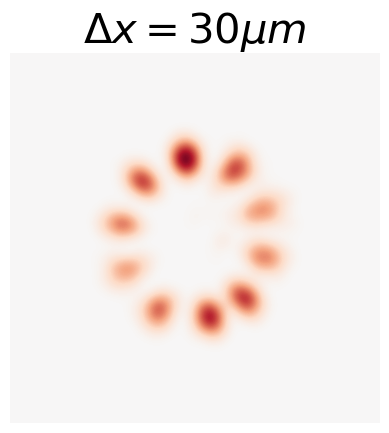

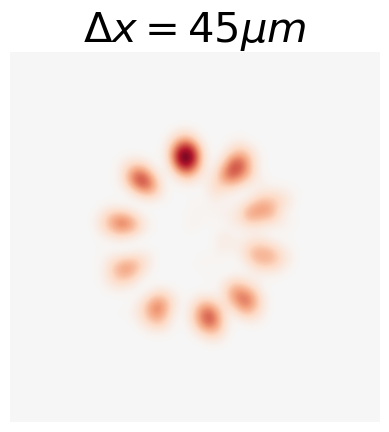

In [22]:
angles2sum = np.linspace(0, 2 * np.pi, 10, endpoint=False)
ind_angles = [np.argmin(np.abs(angles - a)) for a in angles2sum]

for ind, ind_deformation in enumerate(DEFORMATION_TO_SHOW):
    sum_I_rot = np.sum(Ys_focus[ind_deformation, ind_angles, ...], axis=(0))
    sum_I_rot /= np.max(sum_I_rot)

    plt.figure()
    plt.imshow(sum_I_rot, cmap="RdBu_r", interpolation="bicubic", vmin=-1, vmax=1)
    plt.axis("off")

    plt.title(
        rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$", fontsize=SUP_TITLE_SIZE
    )

    if SAVE_FIG:
        plt.savefig(
            image_path(
                f"Rotated_focus_dx_{Delta_x[ind_deformation]:.0f}.svg", full_name=True
            ),
            dpi=300,
        )

### B. Compute field correlation

In [23]:
def prepare(A, mask=None, mean_axis=None):
    """
    Prepare the input for the correlation
    - remove the mean over the dimension `mean_axis` if set
    - apply the `mask` if set
    """

    if mean_axis is not None:
        print(f"Removing mean value over axis {format(mean_axis)}")
        mean_A = np.mean(A, axis=mean_axis, keepdims=True)
        A -= mean_A

    if mask is not None:
        mask = mask.astype(A.dtype)
        A = np.einsum("...k,...k->...k", A, mask)
    return A

In [24]:
# reference fields, i.e. the ones we compare to for the correlation
# with fix the angle vlaue theta to 0

E = Ys_rnd
E_ref = E[..., 0, :]

Corr_rnd_E = stack_correlation(E, E_ref)

Corr_rnd_E_mean = np.mean(Corr_rnd_E, axis=1)
Corr_rnd_E_std = np.std(Corr_rnd_E, axis=1)

==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_RMEcorr_Vs_deform.svg


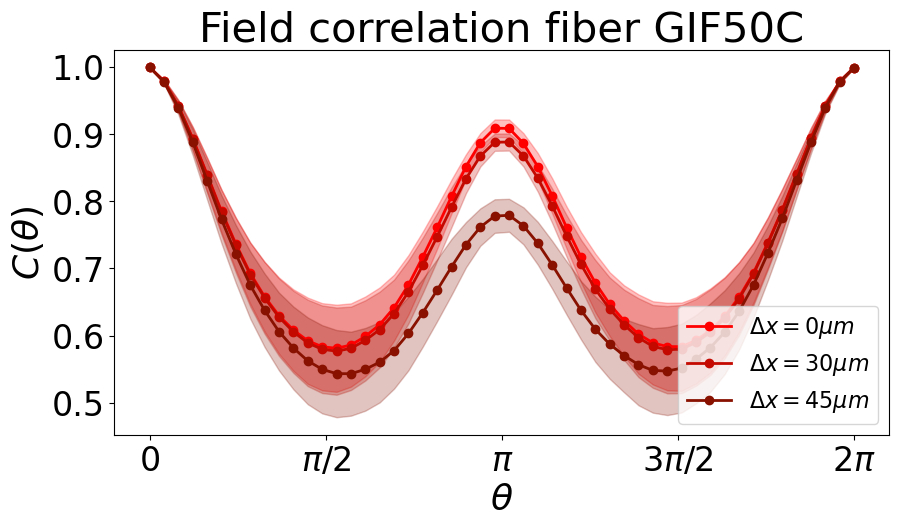

In [25]:
def plot_error(y, y_err, color, type="bars"):
    if type == "bars":
        plt.errorbar(
            angles,
            y,
            yerr=y_err,
            color=color,
            linewidth=2,
            linestyle="None",
            capsize=4,
            capthick=2,
            alpha=0.4,
        )
    if type == "shades":
        plt.fill_between(angles, y - y_err, y + y_err, color=color, alpha=0.25)


def show_RME_corr(show_error=True, save_fig=True):
    deformations2show = DEFORMATION_TO_SHOW
    cmap = get_color_map(n=len(deformations2show) + 1)
    plt.figure(figsize=(10, 5))
    for ind_color, ind_deformation in enumerate(deformations2show):
        color = cmap(ind_color)
        plt.errorbar(
            angles,
            Corr_rnd_E_mean[ind_deformation],
            label=rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$",
            color=color,
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_rnd_E_mean[ind_deformation],
                Corr_rnd_E_std[ind_deformation],
                color=color,
                type="shades",
            )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE - 4, loc="lower right")

    plt.title(
        f"Field correlation fiber {param['fiber']['name']}", fontsize=SUP_TITLE_SIZE
    )

    if save_fig:
        plt.savefig(
            image_path(f"RMEcorr_Vs_deform.svg", full_name=True),
            dpi=300,
        )


show_RME_corr(show_error=True, save_fig=True)

## III. Comparison of intensity and field correlation

### A. Compute correlation from intensity

1. Directly from intensity 
2. Compare to 
$$
    C^E(\theta) = \sqrt{C^I(\theta)}
$$

In [26]:
# remove mean over realization of random input + apply mask
I = prepare(I_rnd, mask=mask_output, mean_axis=(1))

I = I_rnd
# reference image for the first value of the angle
I_ref = I[..., 0, :]

Corr_rnd_I = np.sqrt(stack_correlation(I, I_ref))
Corr_rnd_I_mean = np.mean(Corr_rnd_I, axis=1)
Corr_rnd_I_std = np.std(Corr_rnd_I, axis=1)

Removing mean value over axis 1


/tmp/ipykernel_285847/2028711136.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  mask = mask.astype(A.dtype)


### B. Compare correlation curves for different deformation values

In [27]:
def plot_error(y, y_err, color):
    plt.errorbar(
        angles,
        y,
        yerr=y_err,
        color=color,
        linewidth=2,
        linestyle="None",
        capsize=4,
        capthick=2,
        alpha=0.4,
    )

==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_IvsE_0um.svg
==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_IvsE_30um.svg
==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_IvsE_45um.svg


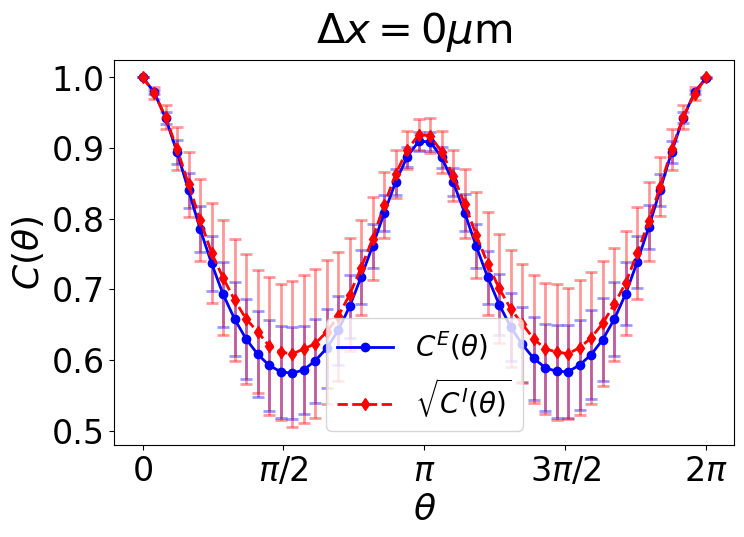

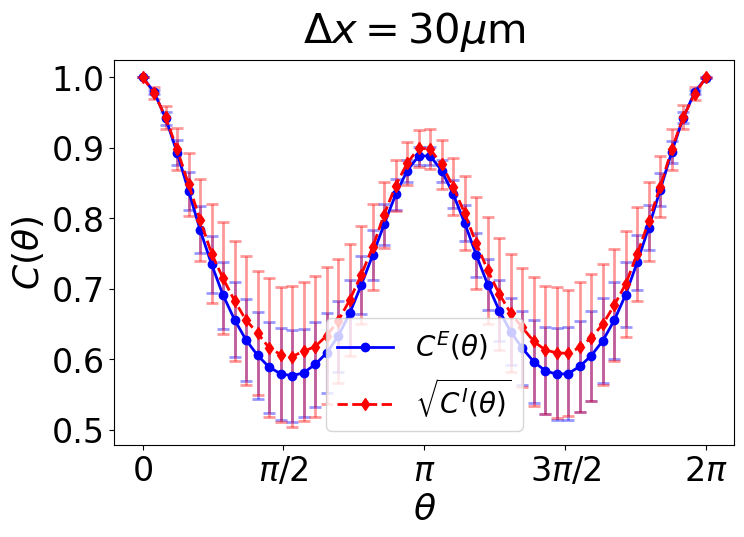

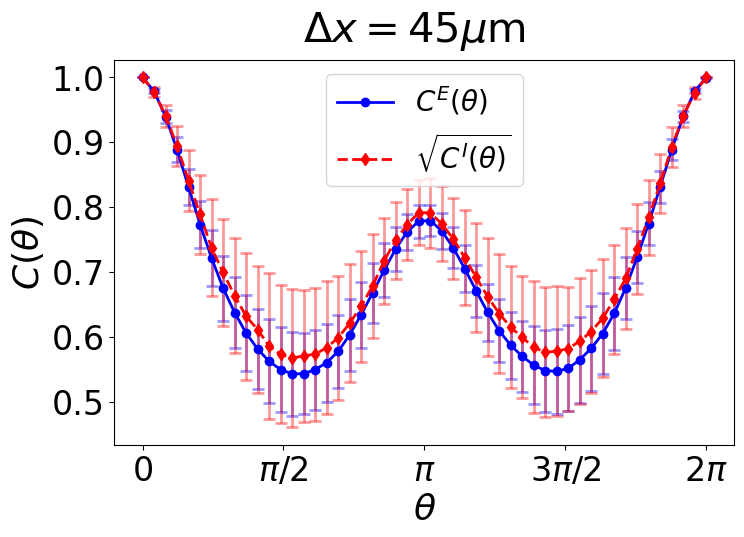

In [36]:
def show_IvsE_corr(ind_deformation, save_fig=True, show_error=False):
    plt.figure(figsize=FIGSIZE)

    plt.errorbar(
        angles,
        Corr_rnd_E_mean[ind_deformation],
        label=r"$C^E(\theta)$",
        color="blue",
        marker="o",
        linewidth=2,
    )

    if show_error:
        plot_error(
            Corr_rnd_E_mean[ind_deformation], Corr_rnd_E_std[ind_deformation], "blue"
        )

    plt.errorbar(
        angles,
        Corr_rnd_I_mean[ind_deformation],
        label=r"$\sqrt{C^I(\theta)}$",
        color="red",
        marker="d",
        linewidth=2,
        linestyle="dashed",
    )

    if show_error:
        plot_error(
            Corr_rnd_I_mean[ind_deformation], Corr_rnd_I_std[ind_deformation], "red"
        )

    if SHOW_GRID:
        plt.grid()
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.suptitle(
        f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m", fontsize=SUP_TITLE_SIZE
    )

    if save_fig:
        plt.savefig(
            image_path(
                f"Corr_IvsE_{Delta_x[ind_deformation]:.0f}um.svg", full_name=True
            ),
            dpi=300,
        )


for ind_deformation in range(np.min((n_deform, len(DEFORMATION_TO_SHOW)))):
    show_IvsE_corr(ind_deformation, show_error=True)

## IV. Estimation of correlation using measured TMs vs experimental measurements

In [37]:
def get_rotation_matrix(m, l, alpha):
    """
    Rotation matrix in the basis of the fiber modes
    m, l are the orbital angular and radial momenta of the modes
    """
    return np.diag(np.exp(1j * np.array(m) * alpha))


R_mats = np.array([get_rotation_matrix(m, l, angle) for angle in angles])

### A. Compute outputs for random inputs + rotation

In [38]:
# random input in the mode basis
E_rnd_in_mode = (np.random.rand(n_rnd, n_modes) - 0.5) + 1j * (
    np.random.rand(n_rnd, n_modes) - 0.5
)

# operator rotation \theta -> TM -> rotation -\theta
Ttheta = np.einsum("aim,dmn,anj->daij", R_mats, TMs, R_mats.conjugate())

# apply to random input fields
Y_rnd_TM_mode = np.einsum("daij,rj->drai", Ttheta, E_rnd_in_mode)

# convert into pixel basis
Y_rnd_TM_pix = np.einsum("ji,...j->...i", Mout.conjugate(), Y_rnd_TM_mode)
I_rnd_TM_pix = np.abs(Y_rnd_TM_pix) ** 2

### B. Compute correlation

In [39]:
# remove average intensity over random inputs
I_rnd_TM_pix = prepare(I_rnd_TM_pix, mask=None, mean_axis=(1))

# reference angle
Y_rnd_TM_ref = Y_rnd_TM_pix[..., 0, :]
I_rnd_TM_ref = I_rnd_TM_pix[..., 0, :]


Corr_rnd_TM_E = stack_correlation(Y_rnd_TM_pix, Y_rnd_TM_ref).squeeze()
Corr_rnd_TM_E_mean = np.mean(Corr_rnd_TM_E, axis=1).squeeze()
Corr_rnd_TM_E_std = np.std(Corr_rnd_TM_E, axis=1)

Corr_rnd_TM_I = np.sqrt(stack_correlation(I_rnd_TM_pix, I_rnd_TM_ref))
Corr_rnd_TM_I_mean = np.mean(Corr_rnd_TM_I, axis=1).squeeze()
Corr_rnd_TM_I_std = np.std(Corr_rnd_TM_I, axis=1).squeeze()

Removing mean value over axis 1


==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_MeasVsTM_0um.svg
==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_MeasVsTM_30um.svg
==> Image path: /home/spopoff/mycore/Articles/2022/RotationalME/git/article_RME_2023/images/TL_GRIN3/TL_GRIN3_Corr_MeasVsTM_45um.svg


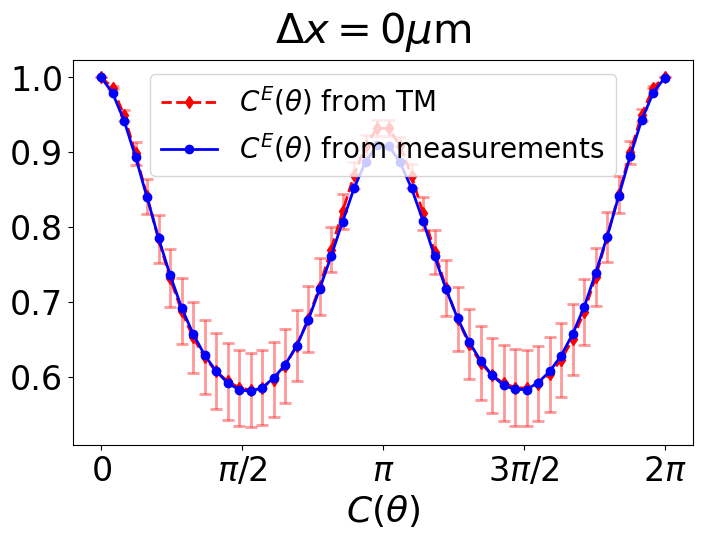

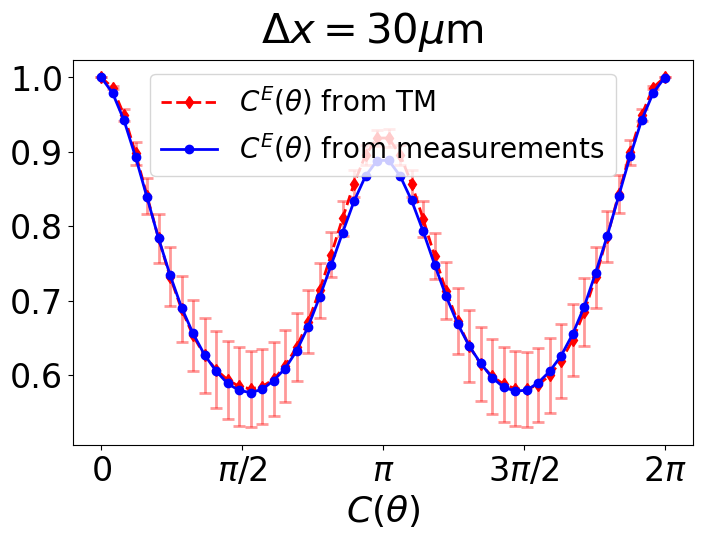

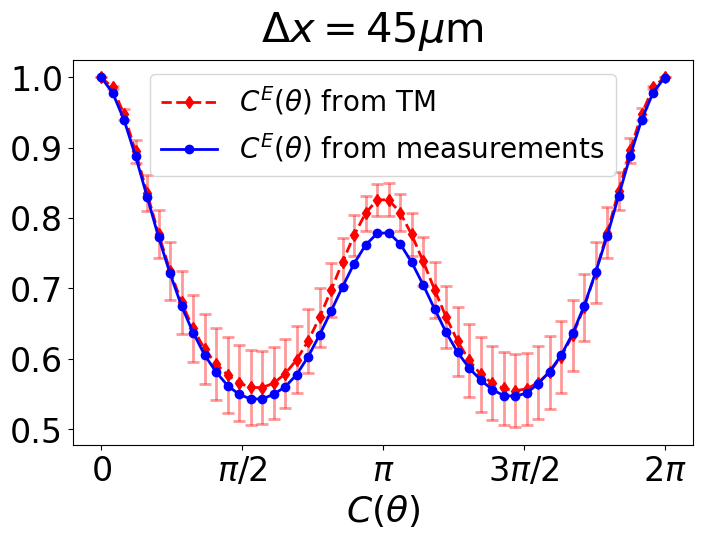

In [41]:
def show_MeasVsTM_corr(
    ind_deformation,
    save_fig=True,
    show_intensity=False,
    show_error=False,
):
    plt.figure(figsize=FIGSIZE)

    plt.errorbar(
        angles,
        Corr_rnd_E_mean[ind_deformation],
        label=r"$C^E(\theta)$ from measurements",
        color="blue",
        marker="o",
        linewidth=2,
    )

    plt.plot(
        angles,
        Corr_rnd_TM_E_mean[ind_deformation],
        label=r"$C^E(\theta)$ from TM",
        color="red",
        marker="d",
        linewidth=2,
        linestyle="dashed",
    )

    if show_error:
        plot_error(
            Corr_rnd_TM_E_mean[ind_deformation],
            Corr_rnd_TM_E_std[ind_deformation],
            color="red",
        )

    if show_intensity:
        plt.errorbar(
            angles,
            Corr_rnd_I_mean[ind_deformation],
            label=r"$\sqrt{C^I(\theta)}$ from measurements",
            color="green",
            marker="x",
            linewidth=2,
            linestyle="dotted",
        )

        if show_error:
            plot_error(
                Corr_rnd_I_mean[ind_deformation],
                Corr_rnd_I_std[ind_deformation],
                color="green",
            )

        plt.errorbar(
            angles,
            Corr_rnd_TM_I_mean[ind_deformation],
            label=r"$\sqrt{C^I(\theta)}$ from TM",
            color="black",
            marker="s",
            linewidth=2,
            linestyle="dashed",
        )

        if show_error:
            plot_error(
                Corr_rnd_TM_I_mean[ind_deformation],
                Corr_rnd_TM_I_std[ind_deformation],
                color="black",
            )

    if SHOW_GRID:
        plt.grid()
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.xlabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.suptitle(
        f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m", fontsize=SUP_TITLE_SIZE
    )

    if save_fig:
        plt.savefig(
            image_path(
                f"Corr_MeasVsTM_{Delta_x[ind_deformation]:.0f}um.svg", full_name=True
            ),
            dpi=300,
        )


for ind_deformation in range(np.min((n_deform, len(DEFORMATION_TO_SHOW)))):
    show_MeasVsTM_corr(
        ind_deformation, save_fig=True, show_intensity=False, show_error=True
    )